# Zyfra   
El presente análisis tiene como objetivo proponer soluciones para la eficiencia de del procesamiento de oro para la empresa Zyfra. Se dividirá en pasos el análisis para poder tener un camino claro de cómo se llegaron a los objetivos y propuestas finales.

## Importación    
Se importan librerías y dataframes para su análisis.

### Librerías y métricas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

### Dataframes

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [4]:
print(df_train.head())

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


### Cálculo de recuperación   
Se recupera el valor de rougher.output.recovery para ver su validez.   
Serevisan valores, los Nan se rellenan con la media ya que los valores máximos y mínimos de las columnas en las que hubo ceros y afectaban el cálculo final, no tenían valores atípicos. Asimismo, se crea una columna con el cáculo de la fórmula de la recuperación para la comparación consecuente y el cálculo de EAM.

In [7]:
df_cálculo = df_train[['rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.concentrate_au']]

In [8]:
df_cálculo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   rougher.input.feed_au          16777 non-null  float64
 1   rougher.output.tail_au         14611 non-null  float64
 2   rougher.output.concentrate_au  16778 non-null  float64
dtypes: float64(3)
memory usage: 395.3 KB


In [9]:
df_cálculo = df_cálculo.dropna(subset=['rougher.input.feed_au', 'rougher.output.tail_au', 'rougher.output.concentrate_au'])
df_cálculo['rougher.output.concentrate_au'] = df_cálculo['rougher.output.concentrate_au'].replace(0, df_cálculo['rougher.output.concentrate_au'].mean())
df_cálculo['rougher.input.feed_au'] = df_cálculo['rougher.input.feed_au'].replace(0, df_cálculo['rougher.input.feed_au'].mean())

In [10]:
C = df_cálculo['rougher.output.concentrate_au']
F = df_cálculo['rougher.input.feed_au']
T = df_cálculo['rougher.output.tail_au']

In [11]:
df_cálculo['cálculo'] = ((C * (F - T)) / (F * (C - T))) * 100

In [12]:
recuperación_1 = df_cálculo['rougher.output.concentrate_au']
recuperación_2 = df_cálculo['cálculo']

n = len(recuperación_1)
suma = 0

for i in range (n):
    suma += abs(recuperación_1.iloc[i] - recuperación_2.iloc[i])
    
error = suma/n

print("EAM es", error)

EAM es 120.03718121171325


**Valor EAM**   

Dado el valor de EAM en el dataframe en cuanto a rougher.output.concentrate_au es alto para los valores de las columnas utilizadas para este cálculo, se presume que la fórmula o el cálculo del dataframe no son confiables en cuanto al valor, por lo que se usará el dataframe base para los análisis posteriores y poder tener mayor confiabilidad. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien, revisaste tus datos y aplicaste las fórmulas requeridas. Es importante en proyectos de este tipo donde se utiliza más teoría entender correctamente las fórmulas que se están utilizando para poder pasarlas a código

### Columnas faltantes en df_test

In [13]:
faltantes = df_train.columns.difference(df_test.columns)
print('Las columnas faltantes en df_test son:')
print(faltantes)

Las columnas faltantes en df_test son:
Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.

Las columnas faltantes varían en su aparente importancia para la propuesta de soluciones que se proveerán en este análisis. Sin embargo, algunas columnas como final.output.concentrate_ag son fundamentales para el análisis que se quiere llevar a cabo. Su tipo son todos float.  

Se usará el dataset completo (df_full) y se segmentará una vez se haya hecho el preprocesamiento de datos para crear conjuntos de entrenamiento, validación y prueba. Se reducirán, además, las proporciones. En lugar de tener un conjunto de validación del 25%, serán:   
-Entrenamiento, 60%   
-Validación, 20%   
-Prueba, 20%

### Preprocesamiento de datos

Se analizan máximos y mínimos para concluir con qué valor se llenan los Nan de cada columna. 

In [14]:
print("Máximos:", df_full.max())
print("Mínimos:", df_full.min())

Máximos: date                                          2018-08-18 10:59:59
final.output.concentrate_ag                             16.001945
final.output.concentrate_pb                             17.031899
final.output.concentrate_sol                             19.61572
final.output.concentrate_au                             53.611374
                                                     ...         
secondary_cleaner.state.floatbank5_a_level            -244.483566
secondary_cleaner.state.floatbank5_b_air                39.846228
secondary_cleaner.state.floatbank5_b_level            -120.190931
secondary_cleaner.state.floatbank6_a_air                54.876806
secondary_cleaner.state.floatbank6_a_level             -29.093593
Length: 87, dtype: object
Mínimos: date                                          2016-01-15 00:00:00
final.output.concentrate_ag                                   0.0
final.output.concentrate_pb                                   0.0
final.output.concentrate_sol    

Se usará mediana para llenar los valores Nan de las columnas excepto la de 'date'.

In [15]:
for columna in df_full.columns:
    if df_full[columna].isna().any():
        df_full[columna] = df_full[columna].fillna(df_full[columna].median())

In [16]:
df_full.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

**Columna 'date'**

Se transforma la columna date de object a datetime. 

In [17]:
print(df_full['date'].head(3))

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
Name: date, dtype: object


In [18]:
df_full['date'] = pd.to_datetime(df_full['date'], format="%Y-%m-%d")

In [19]:
print(df_full['date'].head(3))

0   2016-01-15 00:00:00
1   2016-01-15 01:00:00
2   2016-01-15 02:00:00
Name: date, dtype: datetime64[ns]


## Análisis de datos

### Oro

**Concentrado / pureza**

In [20]:
df_full[['rougher.input.feed_au', 'rougher.output.concentrate_au',
         'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].head(3)

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
0,6.486150,19.793808,34.174427,42.192020
1,6.478583,20.050975,34.118526,42.701629
2,6.362222,19.737170,33.969464,42.657501


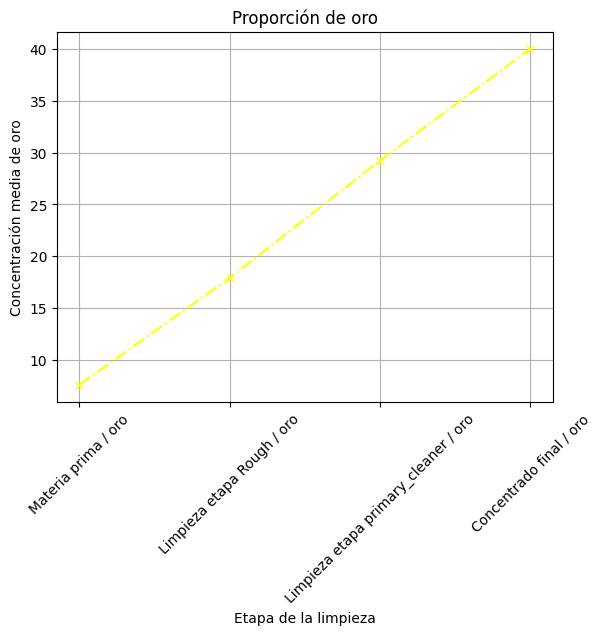

In [21]:
oro_concentrado_columnas = [
    'rougher.input.feed_au', 'rougher.output.concentrate_au',
         'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'
]

etiquetas_oro = ['Materia prima / oro', 'Limpieza etapa Rough / oro', 'Limpieza etapa primary_cleaner / oro',
             'Concentrado final / oro']

valores_medios_oro = [round(df_full[col].mean(), 2) for col in oro_concentrado_columnas]

plt.figure()
plt.plot(etiquetas_oro, valores_medios_oro, marker='x', linestyle='-.', color='yellow')
plt.title('Proporción de oro')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de oro')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [22]:
for etapa, valor in zip(etiquetas_oro, valores_medios_oro):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / oro, Valor medio: 7.57
Etapa: Limpieza etapa Rough / oro, Valor medio: 17.89
Etapa: Limpieza etapa primary_cleaner / oro, Valor medio: 29.23
Etapa: Concentrado final / oro, Valor medio: 40.02


La concentración áurica aumenta conforme la limpieza progresa, esto se debe a que la proporción de oro por tonelada aumenta. 

**Concentrado / pureza tail**

In [23]:
df_full[['rougher.input.feed_au', 'rougher.output.tail_au',
    'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au', 'final.output.tail_au']].head(3)

,rougher.input.feed_au,rougher.output.tail_au,primary_cleaner.output.tail_au,secondary_cleaner.output.tail_au,final.output.tail_au
0,6.486150,1.170244,2.106679,2.606185,2.143149
1,6.478583,1.184827,2.353017,2.488248,2.224930
2,6.362222,1.162562,2.416800,2.458187,2.257889


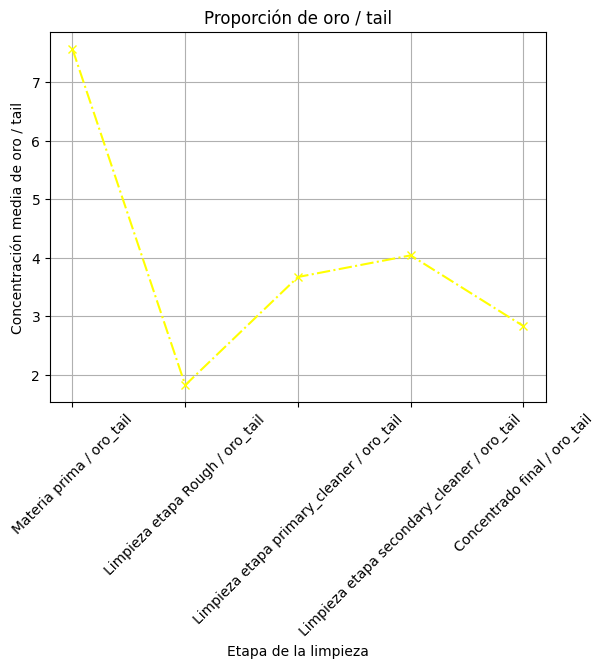

In [24]:
oro_concentrado_columnas_tail = [
    'rougher.input.feed_au', 'rougher.output.tail_au',
    'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au', 'final.output.tail_au'
]

etiquetas_oro_tail = ['Materia prima / oro_tail', 'Limpieza etapa Rough / oro_tail', 'Limpieza etapa primary_cleaner / oro_tail',
             'Limpieza etapa secondary_cleaner / oro_tail', 'Concentrado final / oro_tail']

valores_medios_oro_tail = [round(df_full[col].mean(), 2) for col in oro_concentrado_columnas_tail]

plt.figure()
plt.plot(etiquetas_oro_tail, valores_medios_oro_tail, marker='x', linestyle='-.', color='yellow')
plt.title('Proporción de oro / tail')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de oro / tail')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [25]:
for etapa, valor in zip(etiquetas_oro_tail, valores_medios_oro_tail):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / oro_tail, Valor medio: 7.57
Etapa: Limpieza etapa Rough / oro_tail, Valor medio: 1.82
Etapa: Limpieza etapa primary_cleaner / oro_tail, Valor medio: 3.67
Etapa: Limpieza etapa secondary_cleaner / oro_tail, Valor medio: 4.04
Etapa: Concentrado final / oro_tail, Valor medio: 2.83


La cantidad de oro perdida en tailings es mucho menor que la recuperada, sin embargo, se deben tomar en cuenta los números y compararlos (en caso de tener la masa total final) para poder tener una noción del porcentaje de oro recuperada en sí.   

### Plata

**Concentrado / pureza**

In [26]:
df_full[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
         'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].head(3)

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag
0,6.100378,11.500771,8.547551,6.055403
1,6.161113,11.615865,8.558743,6.029369
2,6.116455,11.695753,8.603505,6.055926


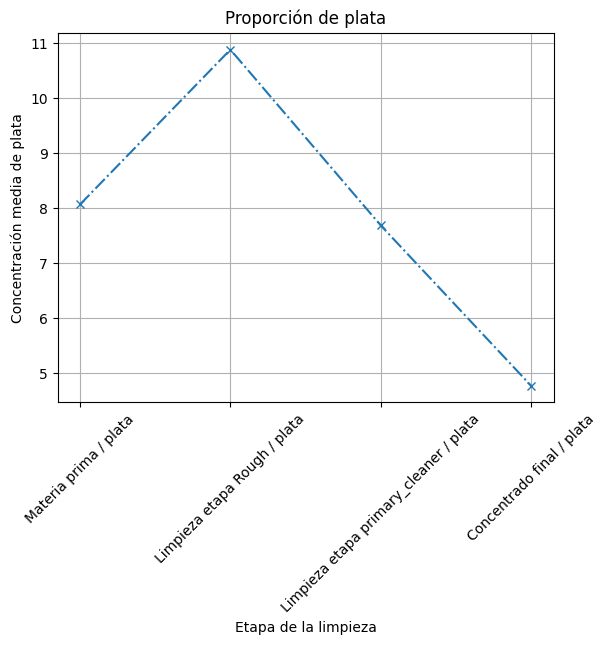

In [27]:
plata_concentrado_columnas = [
    'rougher.input.feed_ag', 'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'
]

etiquetas_plata = ['Materia prima / plata', 'Limpieza etapa Rough / plata', 'Limpieza etapa primary_cleaner / plata',
             'Concentrado final / plata']

valores_medios_plata = [round(df_full[col].mean(), 2) for col in plata_concentrado_columnas]

plt.figure()
plt.plot(etiquetas_plata, valores_medios_plata, marker='x', linestyle='-.')
plt.title('Proporción de plata')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de plata')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [28]:
for etapa, valor in zip(etiquetas_plata, valores_medios_plata):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / plata, Valor medio: 8.07
Etapa: Limpieza etapa Rough / plata, Valor medio: 10.88
Etapa: Limpieza etapa primary_cleaner / plata, Valor medio: 7.69
Etapa: Concentrado final / plata, Valor medio: 4.78


La tendencia de la plata como materia pura va en declive dado que la finalidad del proceso es recuperar el oro y, a pesar de que la plata es materia importante, no es el objetivo. A pesar del aumento dada la limpieza y la mayor concentración de plata por parte, va en declive pues no es la buscada. 

**Concentrado / pureza tail**

In [29]:
df_full[['rougher.input.feed_ag', 'rougher.output.tail_ag',
    'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_ag', 'final.output.tail_ag']].head(3)

,rougher.input.feed_ag,rougher.output.tail_ag,primary_cleaner.output.tail_ag,secondary_cleaner.output.tail_ag,final.output.tail_ag
0,6.100378,5.008018,14.936526,14.500184,10.411962
1,6.161113,4.955378,16.250511,14.265474,10.462676
2,6.116455,4.843460,16.491823,14.115662,10.507046


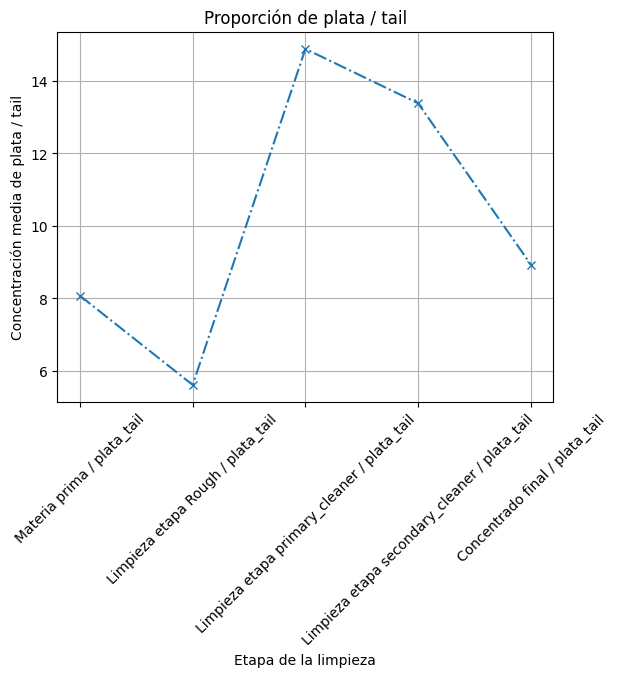

In [30]:
plata_concentrado_columnas_tail = [
    'rougher.input.feed_ag', 'rougher.output.tail_ag',
    'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_ag', 'final.output.tail_ag'
]

etiquetas_plata_tail = ['Materia prima / plata_tail', 'Limpieza etapa Rough / plata_tail', 'Limpieza etapa primary_cleaner / plata_tail',
             'Limpieza etapa secondary_cleaner / plata_tail', 'Concentrado final / plata_tail']

valores_medios_plata_tail = [round(df_full[col].mean(), 2) for col in plata_concentrado_columnas_tail]

plt.figure()
plt.plot(etiquetas_plata_tail, valores_medios_plata_tail, marker='x', linestyle='-.')
plt.title('Proporción de plata / tail')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de plata / tail')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

La tendencia es parecida a la plata concentrada, ya que no es la materia buscada, se va perdiendo en el proceso. 

In [31]:
for etapa, valor in zip(etiquetas_plata_tail, valores_medios_plata_tail):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / plata_tail, Valor medio: 8.07
Etapa: Limpieza etapa Rough / plata_tail, Valor medio: 5.61
Etapa: Limpieza etapa primary_cleaner / plata_tail, Valor medio: 14.88
Etapa: Limpieza etapa secondary_cleaner / plata_tail, Valor medio: 13.38
Etapa: Concentrado final / plata_tail, Valor medio: 8.93


**Suma plata**

### Plomo

**Concentrado / pureza**

In [32]:
df_full[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                  'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].head(3)

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
0,2.284912,7.101074,10.389648,9.889648
1,2.266033,7.278807,10.497069,9.968944
2,2.159622,7.216833,10.354494,10.213995


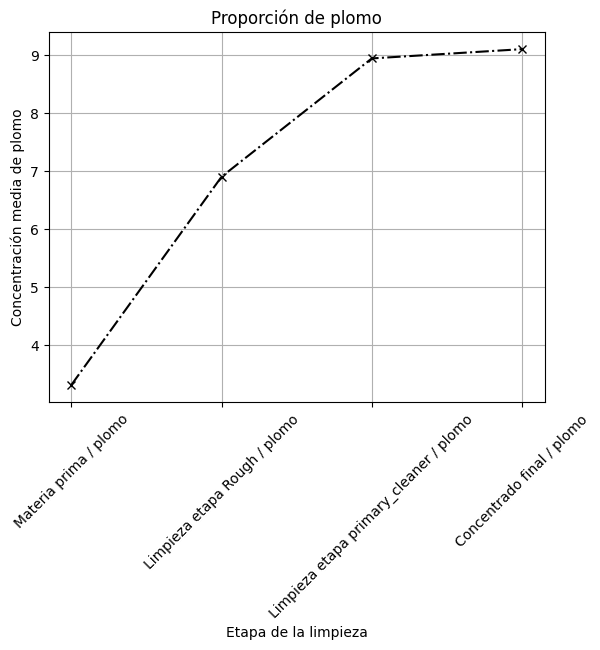

In [33]:
plomo_concentrado_columnas = [
    'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                  'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb'
]

etiquetas_plomo = ['Materia prima / plomo', 'Limpieza etapa Rough / plomo', 'Limpieza etapa primary_cleaner / plomo',
             'Concentrado final / plomo']

valores_medios_plomo = [round(df_full[col].mean(), 2) for col in plomo_concentrado_columnas]

plt.figure()
plt.plot(etiquetas_plomo, valores_medios_plomo, marker='x', linestyle='-.', color='black')
plt.title('Proporción de plomo')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de plomo')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [34]:
for etapa, valor in zip(etiquetas_plomo, valores_medios_plomo):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / plomo, Valor medio: 3.31
Etapa: Limpieza etapa Rough / plomo, Valor medio: 6.9
Etapa: Limpieza etapa primary_cleaner / plomo, Valor medio: 8.94
Etapa: Concentrado final / plomo, Valor medio: 9.1


Conforme se avanza en la limpieza de la materia, la cantidad de plomo por parte aumenta a su vez en la concentración, lo cuál se habrá de tomar en cuenta para la extracción pura del oro.

In [35]:
df_full[['rougher.input.feed_pb', 'rougher.output.tail_pb',
    'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'final.output.tail_pb']].head(3)

,rougher.input.feed_pb,rougher.output.tail_pb,primary_cleaner.output.tail_pb,secondary_cleaner.output.tail_pb,final.output.tail_pb
0,2.284912,0.508728,2.534912,4.694824,0.895447
1,2.266033,0.536689,3.049646,4.592547,0.927452
2,2.159622,0.546416,3.124664,4.624775,0.953716


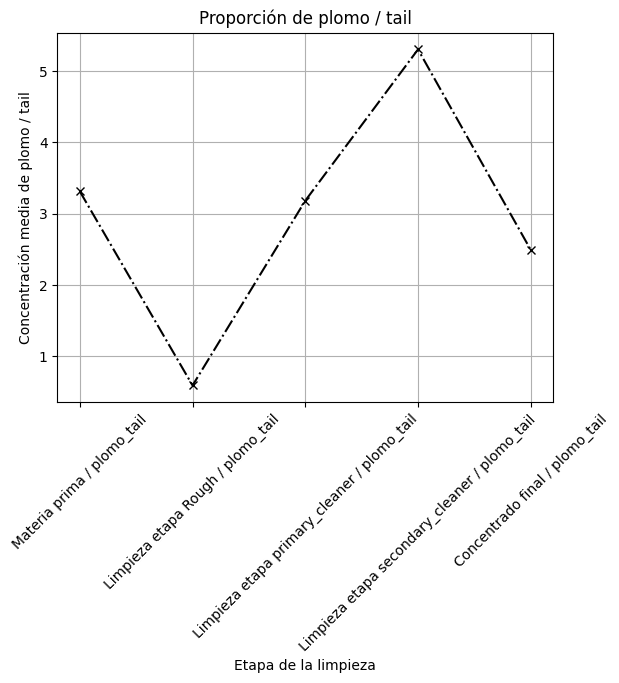

In [36]:
plomo_concentrado_columnas_tail = [
    'rougher.input.feed_pb', 'rougher.output.tail_pb',
    'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'final.output.tail_pb'
]

etiquetas_plomo_tail = ['Materia prima / plomo_tail', 'Limpieza etapa Rough / plomo_tail', 'Limpieza etapa primary_cleaner / plomo_tail',
             'Limpieza etapa secondary_cleaner / plomo_tail', 'Concentrado final / plomo_tail']

valores_medios_plomo_tail = [round(df_full[col].mean(), 2) for col in plomo_concentrado_columnas_tail]

plt.figure()
plt.plot(etiquetas_plomo_tail, valores_medios_plomo_tail, marker='x', linestyle='-.', color='black')
plt.title('Proporción de plomo / tail')
plt.xlabel('Etapa de la limpieza')
plt.ylabel('Concentración media de plomo / tail')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [37]:
for etapa, valor in zip(etiquetas_plomo_tail, valores_medios_plomo_tail):
    print(f'Etapa: {etapa}, Valor medio: {valor}')

Etapa: Materia prima / plomo_tail, Valor medio: 3.31
Etapa: Limpieza etapa Rough / plomo_tail, Valor medio: 0.59
Etapa: Limpieza etapa primary_cleaner / plomo_tail, Valor medio: 3.18
Etapa: Limpieza etapa secondary_cleaner / plomo_tail, Valor medio: 5.3
Etapa: Concentrado final / plomo_tail, Valor medio: 2.49


En el presente análisis, se señalan tanto plomo como plata en tailings dado su posible impacto ambiental durante la extracción áurica. Si bien, se busca aumentar las ganancias, en cuanto a la zona de extracción y las consencuencias ambientales/sociales/políticas, podrían tomarse en cuenta. Además, en estadios posteriores del procesamiento, otros minerales o elementos podrían ser extraídos.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Correcto, analizaste muy bien la distribución de cada metal y redactaste las conclusiones de manera adecuada dejando claro el análisis

### Plomo

**Partículas en rougher.input.feed_size**

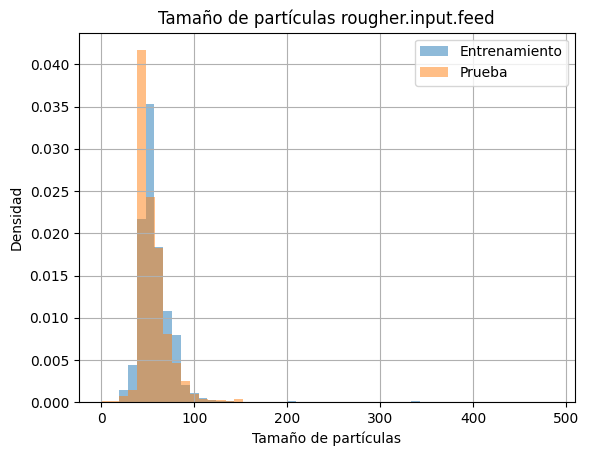

In [38]:
plt.hist(df_train['rougher.input.feed_size'], bins=50, alpha=0.5, label='Entrenamiento', density=True)
plt.hist(df_test['rougher.input.feed_size'], bins=50, alpha=0.5, label='Prueba', density=True)
plt.title('Tamaño de partículas rougher.input.feed')
plt.xlabel('Tamaño de partículas')
plt.ylabel('Densidad')
plt.grid(True)
plt.legend()
plt.show()

**Tamaño de partículas en primary_cleaner.input.feed_size**

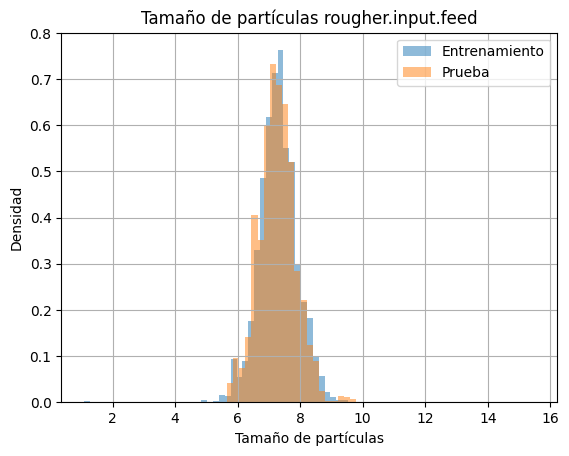

In [39]:
plt.hist(df_train['primary_cleaner.input.feed_size'], bins=50, alpha=0.5, label='Entrenamiento', density=True)
plt.hist(df_test['primary_cleaner.input.feed_size'], bins=50, alpha=0.5, label='Prueba', density=True)
plt.title('Tamaño de partículas rougher.input.feed')
plt.xlabel('Tamaño de partículas')
plt.ylabel('Densidad')
plt.grid(True)
plt.legend()
plt.show()

Al usarse density=True, se puede ver que las distribuciones relativas de ambos data_sets, tanto el de entrenamiento y el de prueba, son parecidos. Esto nos indicaría que se podrían usar para el entrenamiento de nuestro modelo y no afectaría esto los resultados. 

### Valores anormales en concentración

#### Materia prima

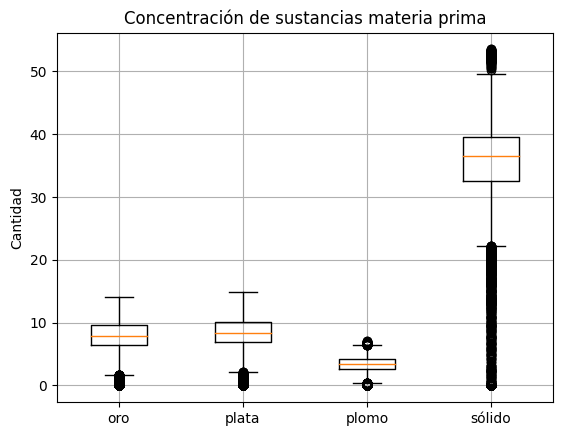

In [40]:
columnas_primera = {
    "oro" : "rougher.input.feed_au",
    'plata' : 'rougher.input.feed_ag',
    'plomo' : 'rougher.input.feed_pb',
    'sólido' : 'rougher.input.feed_sol'   
}

etiquetas = list(columnas_primera.keys())
info = [df_full[col] for col in columnas_primera.values()]

plt.boxplot(info, labels=etiquetas)
plt.title('Concentración de sustancias materia prima')
plt.ylabel('Cantidad')
plt.grid(True)

En la fase inicial, en todas las materias, hay valores atípicos, sin embargo, al ser la cantidad mucha, podríase optar por una escalada de valores para el entrenamiento de los modelos.

#### Salida rougher

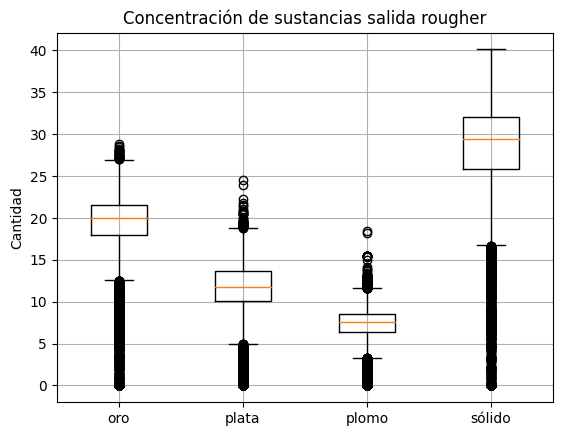

In [41]:
columnas_segunda = {
    "oro" : "rougher.output.concentrate_au",
    'plata' : 'rougher.output.concentrate_ag',
    'plomo' : 'rougher.output.concentrate_pb',
    'sólido' : 'rougher.output.concentrate_sol'
}

etiquetas_2= list(columnas_segunda.keys())
info_2 = [df_full[col] for col in columnas_segunda.values()]

plt.boxplot(info_2, labels=etiquetas_2)
plt.title('Concentración de sustancias salida rougher')
plt.ylabel('Cantidad')
plt.grid(True)

En la segunda etapa también hay aparición de valores atípicos, sin embargo, en comparación con la previa etapa, aquí oro, plata y plomo tienen más que antes. 

#### Salida primary_cleaner.output

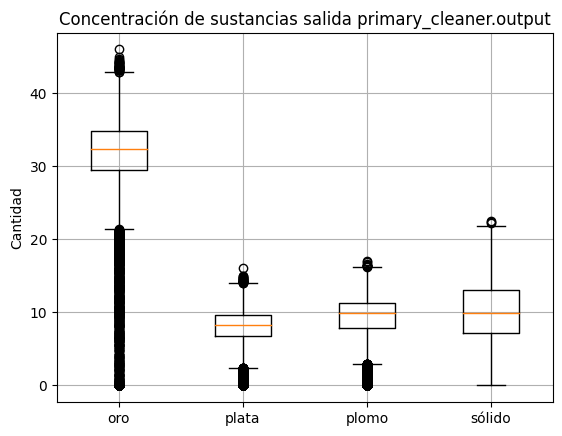

In [42]:
columnas_tercera = {
    "oro" : "primary_cleaner.output.concentrate_au",
    'plata' : 'primary_cleaner.output.concentrate_ag',
    'plomo' : 'primary_cleaner.output.concentrate_pb',
    'sólido' : 'primary_cleaner.output.concentrate_sol'
}

etiquetas_3= list(columnas_tercera.keys())
info_3 = [df_full[col] for col in columnas_tercera.values()]

plt.boxplot(info_3, labels=etiquetas_3)
plt.title('Concentración de sustancias salida primary_cleaner.output')
plt.ylabel('Cantidad')
plt.grid(True)

En la etapa final, oro es la que tiene más valores atípicos, lo cual es lógico, ya que es la materia siendo extraída. Eliminar los valores atípicos significaría la pérdida de muchos valores que podrían afectar los cálculos posteriores, por lo que se escalarán los datos para probar el funcionamiento de los modelos. 

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

El análisis fue realizado correctamente, este es un paso importante antes de pasar a ejecutar cualquier otro paso de negocio o de modelado usando Machine Learning

## División y escalado de datos

Se segmenta el df_full en 3 partes:   
-60% de entrenamiento   
-20 % de validación    
-20% de prueba

In [43]:
target = df_full['final.output.concentrate_ag']
features = df_full.drop(['final.output.concentrate_ag', 'date'], axis=1)

x_temp, x_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=12345)

In [44]:
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state=12345)

In [45]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

## Construcción de modelo   
Se comienza con la comparación de modelos en escenarios ideales y luego se crea la función sMAPE y se usan para métricas de evaluación. 

**Regresión linear** 

In [46]:
model_lineal = LinearRegression()
model_lineal.fit(x_train, y_train)

predictions_lineal = model_lineal.predict(x_val)

mse_lineal = mean_squared_error (y_val, predictions_lineal)
rmse_lineal = mse_lineal**0.5

r2_lineal = r2_score(y_val, predictions_lineal)

final_lineal = cross_val_score(model_lineal, x_temp, y_temp, cv=5).mean()

print('El valor de R2 es', r2_lineal)
print('El valor de RMSE es', rmse_lineal)
print('El promedio de evaluación del modelo es', final_lineal)

El valor de R2 es 0.824655721996291
El valor de RMSE es 0.857103278613901
El promedio de evaluación del modelo es 0.8138632903767237


En el modelo de regresión linear, nos indica R2 que el modelo logra explicar el 82.4% de la variabilidad en cuanto a nuestro objetivo.      
El error promedio es de 0.86, lo cual quiere decir que es un error moderado en cuanto a predicciones.   
Finalmente, la calificación final nos sugiere que el desempeño del modelo es consistente en cuanto a sus parámetros. 

**Decision Tree Regressor**

In [47]:
mejor_modelo = None
mejor_resultado = 10000
mejor_profundidad = 0
mejor_r2 = 0
mejor_promedio = 0

for profundidad in range (1, 10):
    model_tree=DecisionTreeRegressor(random_state=12345, max_depth=profundidad)
    model_tree.fit(x_train, y_train)
    
    predictions_tree = model_tree.predict(x_val)
    
    mse_tree = mean_squared_error(y_val, predictions_tree)
    rmse_tree = mse_tree**0.5
       
    r2_tree = r2_score(y_val, predictions_tree)
    final_tree = cross_val_score(model_tree, x_temp, y_temp, cv=5).mean()
    
    if rmse_tree < mejor_resultado:
        mejor_modelo = model_tree
        mejor_resultado = rmse_tree
        mejor_profundidad = profundidad
        mejor_r2 = r2_tree
        mejor_promedio = final_tree
        
print(f'Mejor profundidad: {mejor_profundidad}')
print(f'RMSE: {mejor_resultado}')
print(f'R2: {mejor_r2}')
print(f'Promedio de modelo: {mejor_promedio}')

Mejor profundidad: 9
RMSE: 0.6541617770144578
R2: 0.8978600562417903
Promedio de modelo: 0.8856209818216728


El RMSE nos indica una equivocación de .65 en cuanto a las predicciones realizadas.     
Dentro de este error, el R2 nos indica que el modelo funciona bien en cuanto a la precisión y la generalización de los datos proporcionados.    
El promedio final coincide con el R2, lo cual es idóneo. 

El modelo del árbol resulta en mejores resultados en canto al rmse y el promedio de modelo resulta también aceptable, por lo que es el que se usará para las mediciones finales.

### sMAPE    
Se procede con la creación de una función que calcule el valor final de sMAPE.

In [48]:
def sMAPE(y_test, y_pred):
    suma = 0
    for test, pred in zip(y_test, y_pred):
        arriba = abs(test - pred)
        abajo = (abs(test) + abs(pred)) / 2
        if abajo != 0:
            suma_p = arriba / abajo
            suma += suma_p
        else:
            suma += 0
    
    sumape = (suma / len(y_test)) * 100
    
    return sumape

In [49]:
def sMAPEfinal(srougher, sfinal):
    final_s = (.25 * srougher) + (.75 * sfinal)
    return final_s

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy bien planteadas las formulas para obtener la métrica mencionada, es importante manejar la matemática a utilizar en los proyectos

## Prueba final

**Modelo con rougher**

In [50]:
x_rou = df_full.drop(['rougher.output.recovery', 'date'], axis=1)
y_rou = df_full['rougher.output.recovery']

x_rou_temp, x_rou_test, y_rou_temp, y_rou_test = train_test_split(x_rou, y_rou, test_size=0.2, random_state=12345)
x_rou_train, x_rou_val, y_rou_train, y_rou_val = train_test_split(x_rou_temp, y_rou_temp, test_size=0.25, random_state=12345)

model_rou = DecisionTreeRegressor(random_state=12345, max_depth=9)
model_rou = model_rou.fit(x_rou_train, y_rou_train)

pred_rou = model_rou.predict(x_rou_test)

smape_rou = sMAPE(y_rou_test, pred_rou)

print(f'El valor de sMAPE de rougher.output.recovery es: {smape_rou}')

El valor de sMAPE de rougher.output.recovery es: 2.1347570256413944


**Modelo con final.output.recovery**

In [51]:
x_out = df_full.drop(['final.output.recovery', 'date'], axis=1)
y_out = df_full['final.output.recovery']

x_out_temp, x_out_test, y_out_temp, y_out_test = train_test_split(x_out, y_out, test_size=0.2, random_state=12345)
x_out_train, x_out_val, y_out_train, y_out_val = train_test_split(x_out_temp, y_out_temp, test_size=0.25, random_state=12345)

model_out = DecisionTreeRegressor(random_state=12345, max_depth=9)
model_out = model_out.fit(x_out_train, y_out_train)

pred_out = model_rou.predict(x_out_test)

smape_out = sMAPE(y_out_test, pred_out)

print(f'El valor de sMAPE de final.output.recovery es: {smape_out}')

El valor de sMAPE de final.output.recovery es: 31.65445903988945


**sMAPE final**

In [52]:
sMAPEfinal(smape_rou, smape_out)

24.274533536327436

In [53]:
df_full[['final.output.recovery', 'final.output.concentrate_au', 'final.output.tail_au']].mean()

final.output.recovery          67.523081
final.output.concentrate_au    40.018785
final.output.tail_au            2.827767
dtype: float64

## Conclusión

La métrica final mMAPE nos indica un error simétrico del 24.27% en la extracción de oro. Una cantidad importante dadas las cantidades obtenidas. A continuación, las propuestas:    
-Se debe tomar en cuenta la probable mejora del modelo, ya que se usó escalado de datos para el entrenamiento del modelo, pero no se escaló target(y), así que habríase de considerar para medir con cuidado sMAPE final.    
-Si bien, los procesos actuales de Zyfra permiten extraer imporantes cantidades de materia, podríase eficientar el proceso o tener otro proceso con el sobrante de los tailings.   
-En caso de que se buscara eficientar la extracción de oro, habríase de revisar el procedimiento y rectificar la información obtenida al momento de este análisis.    
-Asimismo, la empresa podría utilizar aquellos materiales que no son exactamente oro para aumentar ya sean las ganancias o el mismo proceso de extracción; asimismo, considerar estos elementos secundarios y su posible impacto en el ambiente una vez extraída la materia requerida.    
-Se deben considerar las importantes cantidades de valores atípicos, pues estos afectan los cálculos. A pesar de que ser eliminados del cálculo, era opción, se consideró que se perdería información valiosa pues estas variaciones también son parte ya sea de las ganancias o las pérdidas, por eso se tomaron en cuenta como factor de análisis.

<div class="alert alert-block alert-success">
<b>Comentario del revisor (1ra Iteracion)</b> <a class=“tocSkip”></a>

Muy buen trabajo, realizaste los pasos al pie de la letra con un análisis detallado de cada punto. Te recomendaría que las conclusiones las detalles un poco más en base también a las gráficas que pudiste analizar en el proyecto, las conclusiones finales son como el resúmen de tu proyecto por lo que hay que incluir los puntos importantes encontrados desde el principio del proyecto. Saludos!